# Main CNN model for bat call classification

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# dont use gpu [for M1/M2 Metal, cause it cant handle Dropout Layers too well], comment out if you want to use GPU
physical_devices = tf.config.list_physical_devices('GPU')  
tf.config.set_visible_devices(physical_devices[1:], 'GPU')
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K 
import gc
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import KFold,StratifiedKFold
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import EditedNearestNeighbours as ENN
from imblearn.combine import SMOTEENN, SMOTETomek
from tensorflow.keras import regularizers
import tensorflow_model_optimization as tfmot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json
from sklearn.utils import shuffle
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.applications.resnet50 import ResNet50

In [2]:
data = pd.read_pickle('./data/images_df_numerical.pkl')
counts = data["Species"].value_counts()
print("Counts original: ",counts)

# exclude all classes with less then 200 samples
data = data[data['Species'].isin(counts[counts>=500].index)]
data["Species"][data["Species"]==2] = 1
counts = data["Species"].value_counts()
print("Counts Reduced: ",counts)

classes = data["Species"].unique()
number_of_classes = classes.size

# Alleiniges undersampling wird keinen Sinn machen, da wir extrem wenig Datenpunkte overall haben
def resample(resampler) -> tuple[np.array, np.array]:
    X, y = data['data'], data['Species']
    X, y = np.stack(X).astype(np.uint8), y.to_numpy().astype(np.uint8)
    X_resampled, y_resampled = resampler.fit_resample(X, y)

    print(f"{resampler}: ", pd.Series(y_resampled, dtype=pd.UInt8Dtype()).value_counts())

    X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=1)

    return X_resampled, y_resampled

def resample_after_split(X,y) -> tuple[np.array, np.array]:
    n, h, w, _ = X.shape
    X = X.reshape((n, h * w * 3))
    _,val = np.unique(y, return_counts=True)
    print("Distribution befor res:",val)
    X_resampled, y_resampled = SMOTEENN(sampling_strategy='all',enn=ENN(kind_sel='mode',n_neighbors=7)).fit_resample(X, y)
    _,val = np.unique(y_resampled, return_counts=True)
    print("Distribution after res:",val)
    X_resampled = X_resampled.reshape((-1,) + image_shape) 
    #print(f"{resampler}: ", pd.Series(y_resampled, dtype=pd.UInt8Dtype()).value_counts())

    X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=1)
    return X_resampled, y_resampled

# oversampling
adasyn = ADASYN()

#X, y = resample(adasyn)
X, y = data['data'], data['Species']
X, y = np.stack(X).astype(np.uint8), y.to_numpy().astype(np.uint8)

Counts original:  Species
0    2104
2     866
3     290
1     270
4     123
5      69
Name: count, dtype: int64
Counts Reduced:  Species
0    2104
1     866
Name: count, dtype: int64


In [3]:
image_size = X[0].size
samples = X.size
with open("./data/meta.json","r") as file:  # get metadata for images from file generated from import nb
    image_meta = json.load(file) 
image_shape = (image_meta['h'],image_meta['w'],image_meta['c']) # hwc
print("Image has shape", image_shape)
# normalize to 0-1


X = X / 255.
X = X.reshape((-1,) + image_shape)    #after resample
# denoise
#autoencoder = tf.keras.saving.load_model('./ae_files/denoise_autoencoder_cnn.keras')
#X = autoencoder.predict(X)

Image has shape (82, 128, 3)


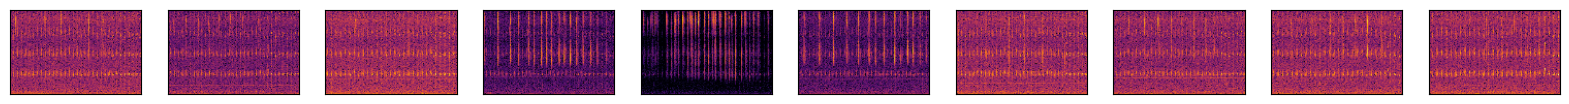

In [4]:
# show sample of generated images
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    if image_shape[2]==1:
        plt.imshow((X[i]*255.).astype('uint8'),cmap='inferno',vmin=0, vmax=255) # for grayscale images
    elif image_shape[2]==4 or image_shape[2]==3:
        plt.imshow(cv2.cvtColor((X[i]*255.).astype('uint8'),cv2.COLOR_BGR2RGB)) # for rgb images
    
    #plt.color()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [5]:
kfold = StratifiedKFold(n_splits=2, shuffle=True) # orig n=10 splits  # or KFold; stratifiedKfols keeps labal proportions accross splits

tf.keras.utils.set_random_seed(1)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

In [6]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, min_delta=0.001, start_from_epoch=15, restore_best_weights=True)
epochs = 200
batch_size = 32
dropout_rate = 0.2 #or 0.3 # https://www.kaggle.com/code/rafjaa/dealing-with-very-small-datasets interessant bzgl oberfitting
weight_decay_alpha = 0.01 # or 0.015

def create_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=image_shape,name="aaa"))
    model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    #model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay_alpha)))
    #model.add(tf.keras.layers.BatchNormalization())
    #model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(number_of_classes, activation='softmax'))

    return model

In [7]:
def fit_model(model, X_train, y_train, X_val=None, y_val=None, worker=8):
    if X_val is None or y_val is None:
        history = model.fit(
            X_train,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            workers=worker, # workers are number of cores
            callbacks=[early_stopping, tfmot.sparsity.keras.UpdatePruningStep()],
            validation_split=0.2,
            verbose=1)
    elif X_val is not None and y_val is not None:
        history = model.fit(
            X_train,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            workers=worker, # workers are number of cores
            callbacks=[early_stopping, tfmot.sparsity.keras.UpdatePruningStep()],
            validation_data=(X_val,y_val),
            verbose=1)
    return history

In [8]:
end_step = np.ceil(X.shape[0] / batch_size).astype(np.int32) * epochs

pruning_params = {
    # In this example, you start the model with 50% sparsity (50% zeros in weights) and end with 80% sparsity.
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                                final_sparsity=0.80,
                                                                begin_step=0,
                                                                end_step=end_step)}

model = create_model()
model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

In [ ]:
# for confusion_matrix
true_labels = list()
pred_labels = list()
train_accuracies = list()
test_accuracies = list()
val_accuracies = list()
train_losses = list()
val_losses = list()
test_losses = list()

for train_indezes, test_indezes in kfold.split(X, y):
    K.clear_session()
    # Get the current Data
    X_train, X_val, y_train, y_val = train_test_split(X[train_indezes], y[train_indezes], test_size=0.2,stratify=y[train_indezes], random_state=42)
    X_test, y_test = X[test_indezes], y[test_indezes]

    # resample Validation and Train Data
    X_train, y_train = resample_after_split(X_train, y_train)
    X_val, y_val = resample_after_split(X_val, y_val)

    # Compile & Fit Model
    X_train, y_train = tf.convert_to_tensor(X_train), tf.convert_to_tensor(y_train)
    X_test, y_test = tf.convert_to_tensor(X_test), tf.convert_to_tensor(y_test)
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    history = fit_model(model, X_train, y_train, X_val, y_val)

    # for confusion matrix
    predictions = np.argmax(model.predict(X_test), axis=-1)
    true_labels.extend(y_test)
    pred_labels.extend(predictions)

    # for accuracy curves
    train_accuracies.extend(history.history['accuracy'])
    val_accuracies.extend(history.history['val_accuracy'])

    # for loss curves
    train_losses.extend(history.history['loss'])
    val_losses.extend(history.history['val_loss'])

    loss, accuracy = model.evaluate(X_test, y_test)
    test_accuracies.append(accuracy)
    test_losses.append(loss)

Distribution befor res: [842 346]
Distribution after res: [842 841]
Distribution befor res: [210  87]
Distribution after res: [210 208]
Epoch 1/200
53/53 [==============================] - 5s 47ms/step - loss: 7.6429 - accuracy: 0.7683 - val_loss: 9.4163 - val_accuracy: 0.4976
Epoch 2/200
53/53 [==============================] - 2s 46ms/step - loss: 5.0924 - accuracy: 0.8295 - val_loss: 5.0621 - val_accuracy: 0.4976
Epoch 3/200
53/53 [==============================] - 2s 44ms/step - loss: 3.2611 - accuracy: 0.8437 - val_loss: 4.8976 - val_accuracy: 0.4976
Epoch 4/200
53/53 [==============================] - 2s 47ms/step - loss: 2.3930 - accuracy: 0.8752 - val_loss: 4.2515 - val_accuracy: 0.4976
Epoch 5/200
53/53 [==============================] - 2s 47ms/step - loss: 1.9273 - accuracy: 0.8871 - val_loss: 4.5948 - val_accuracy: 0.4976
Epoch 6/200
53/53 [==============================] - 3s 50ms/step - loss: 1.6349 - accuracy: 0.8800 - val_loss: 4.7775 - val_accuracy: 0.4976
Epoch 7/200


In [ ]:
## VGG19 als Vergleich zu unserem
#
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, min_delta=0.001, start_from_epoch=15, restore_best_weights=True)
#epochs = 200
#batch_size = 32
#
#vgg19_test_accuracies = list()
#
#base_model = ResNet50(weights='imagenet', include_top=False, input_shape=image_shape) # VGG19 or ResNet50
#
## Freeze the convolutional base
#for layer in base_model.layers:
#    layer.trainable = False
#
#model = Sequential()
#model.add(base_model)
#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
##model.add(Dense(6, activation='softmax'))
#
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#
#for train_indezes, test_indezes in kfold.split(X, y):
#    K.clear_session()
#    X_train, y_train = tf.convert_to_tensor(X[train_indezes]), tf.convert_to_tensor(y[train_indezes])
#    X_test, y_test = tf.convert_to_tensor(X[test_indezes]), tf.convert_to_tensor(y[test_indezes])
#    history = model.fit(X_train, y_train, batch_size=batch_size, callbacks=[early_stopping], epochs=epochs, validation_split=0.2, verbose=1)
#    _, accuracy = model.evaluate(X_test, y_test)
#    vgg19_test_accuracies.append(accuracy)
#    

In [ ]:
confusion_matrix = confusion_matrix(true_labels, pred_labels)
fig, ax = plt.subplots(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix, display_labels=classes)
cm_display.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Plotting the training and validation curves
epochs = len(train_losses)
plt.figure(figsize=(12, 4))

# Plotting loss curves
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("./cnn_files/loss_and_accuraccy.png")
plt.show()

In [ ]:
#print(f"VGG19 Avg. test accuracy: {sum(vgg19_test_accuracies) / len(vgg19_test_accuracies)}") # usually 83%

print(f"Avg. Val accuracy: {sum(val_accuracies) / len(val_accuracies)}")
print(f"Best Val Accuracy: {max(val_accuracies)}")
print(f"Avg. Test accuracy: {sum(test_accuracies) / len(test_accuracies)}")
print(f"Best Test Accuracy: {max(test_accuracies)}")   # with top 4 classes: 81%; with >60: %
print(f"Test loss: {sum(test_losses) / len(test_losses)}")
print(test_accuracies)


Ergebnisse:
|Durchführung|Avg. Test Acc|
|:-|-:|
| Kein Resample, top 6 classes (> 60), vgg19| 82% |
| Kein Resample, top 4 classes (>200), vgg19| 83% |
| Kein Resample, top 2 classes (>500), vgg19| 91% |
|---------------|
| Kein Resample, top 6 classes (> 60), resNet50| 70% |
| Kein Resample, top 4 classes (>200), resNet50| 74% |s
| Kein Resample, top 2 classes (>500), resNet50| 84% |
|---------------|
| Kein Resample, top 6 classes (> 60), cnn  | 79% |
| Kein Resample, top 4 classes (>200), cnn  | 83% |
| Kein Resample, top 2 classes (>500), cnn  | 87% |
|---------------|
| Train & Validation Resample (Smotteen(all,enn=Mode,n=3)), top 6 classes (> 60), cnn   | 63% |
| Train & Validation Resample (Smotteen(all,enn=Mode,n=3)), top 4 classes (>200), cnn   | 80% |
| Train & Validation Resample (Smotteen(all,enn=Mode,n=3)), top 2 classes (>500), cnn   | 87% |
|---------------|
| Train & Validation Resample (Smotteen(all,enn=Mode,n=7)), top 6 classes (> 60), cnn   | % |
| Train & Validation Resample (Smotteen(all,enn=Mode,n=7)), top 4 classes (>200), cnn   | 79% |
| Train & Validation Resample (Smotteen(all,enn=Mode,n=7)), top 2 classes (>500), cnn   | % |
|---------------|
| Train Resample (Smotteen(all,enn=Mode,n=3)), top 6 classes (> 60), cnn   | 73% |
| Train Resample (Smotteen(all,enn=Mode,n=3)), top 4 classes (>200), cnn   | 81% |
| Train Resample (Smotteen(all,enn=Mode,n=3)), top 2 classes (>500), cnn   | 88% |
